# **Housing Price Prediction**

This notebook is a walkthrough of Aurélien Géron's housing price prediction model using Califrornia Housing Prices dataset from the StatLib repository. This project is guided by his *Hands-On Machine Learning with Scikit-Learn & TensorFlow* with minor adjustments and modifications of my own.

It aims at predicting the median housing price for districts in California. Districts typically being geographical units comprising of 600-3000 people.

## Common Imports and Setup

In [1]:
import sys
import sklearn
import os
import matplotlib as mpl


#Python >= 3.5 & sklearn >= 0.20
assert sys.version_info >= (3, 5)
assert sklearn.__version__ >=  '0.20'

#Figure setup for good visualizations
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Fetching the Data

In [2]:
import tarfile
import urllib.request
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join(os.getcwd(), "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  """Downloading the housing data
  """
  if not os.path.isdir(housing_path):
      os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()


In [3]:
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    """Loading the data"""
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [4]:
#data manipulation and linear algebra libraries
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

#preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#feature engineering
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

#Model Selection and Training


## Exploratory Data Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
housing.head()
#To get a glimpse of the data using the top 5 rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We notice that there are 10 atributes in the data. We can however still get information on the number of instances, the number of missing values, as well as the data type for each attribute in order to apply the appropriate statistical measures.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
#Some escriptive statics for the numerical attributes
housing.describe() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
housing['ocean_proximity'].value_counts() 
#exploring the categorical variable

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

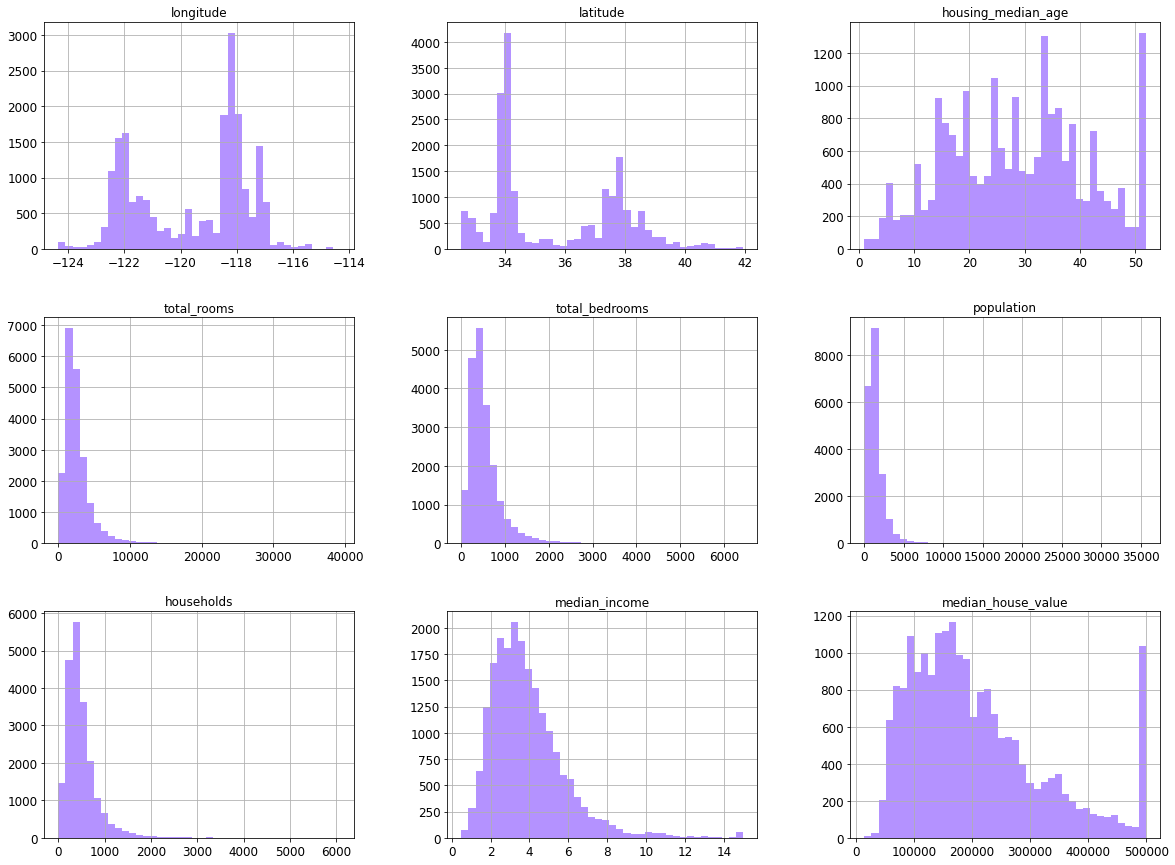

In [10]:
#Checking the data distribution of the attributes
housing.hist(bins=40, figsize=(20,15), color ='#b492ff')
plt.show()

Apart from median house age, most of the attributes are heavily skewed to the left, with largely differing scales. Also, the feature median income has been scaled and capped at 15.

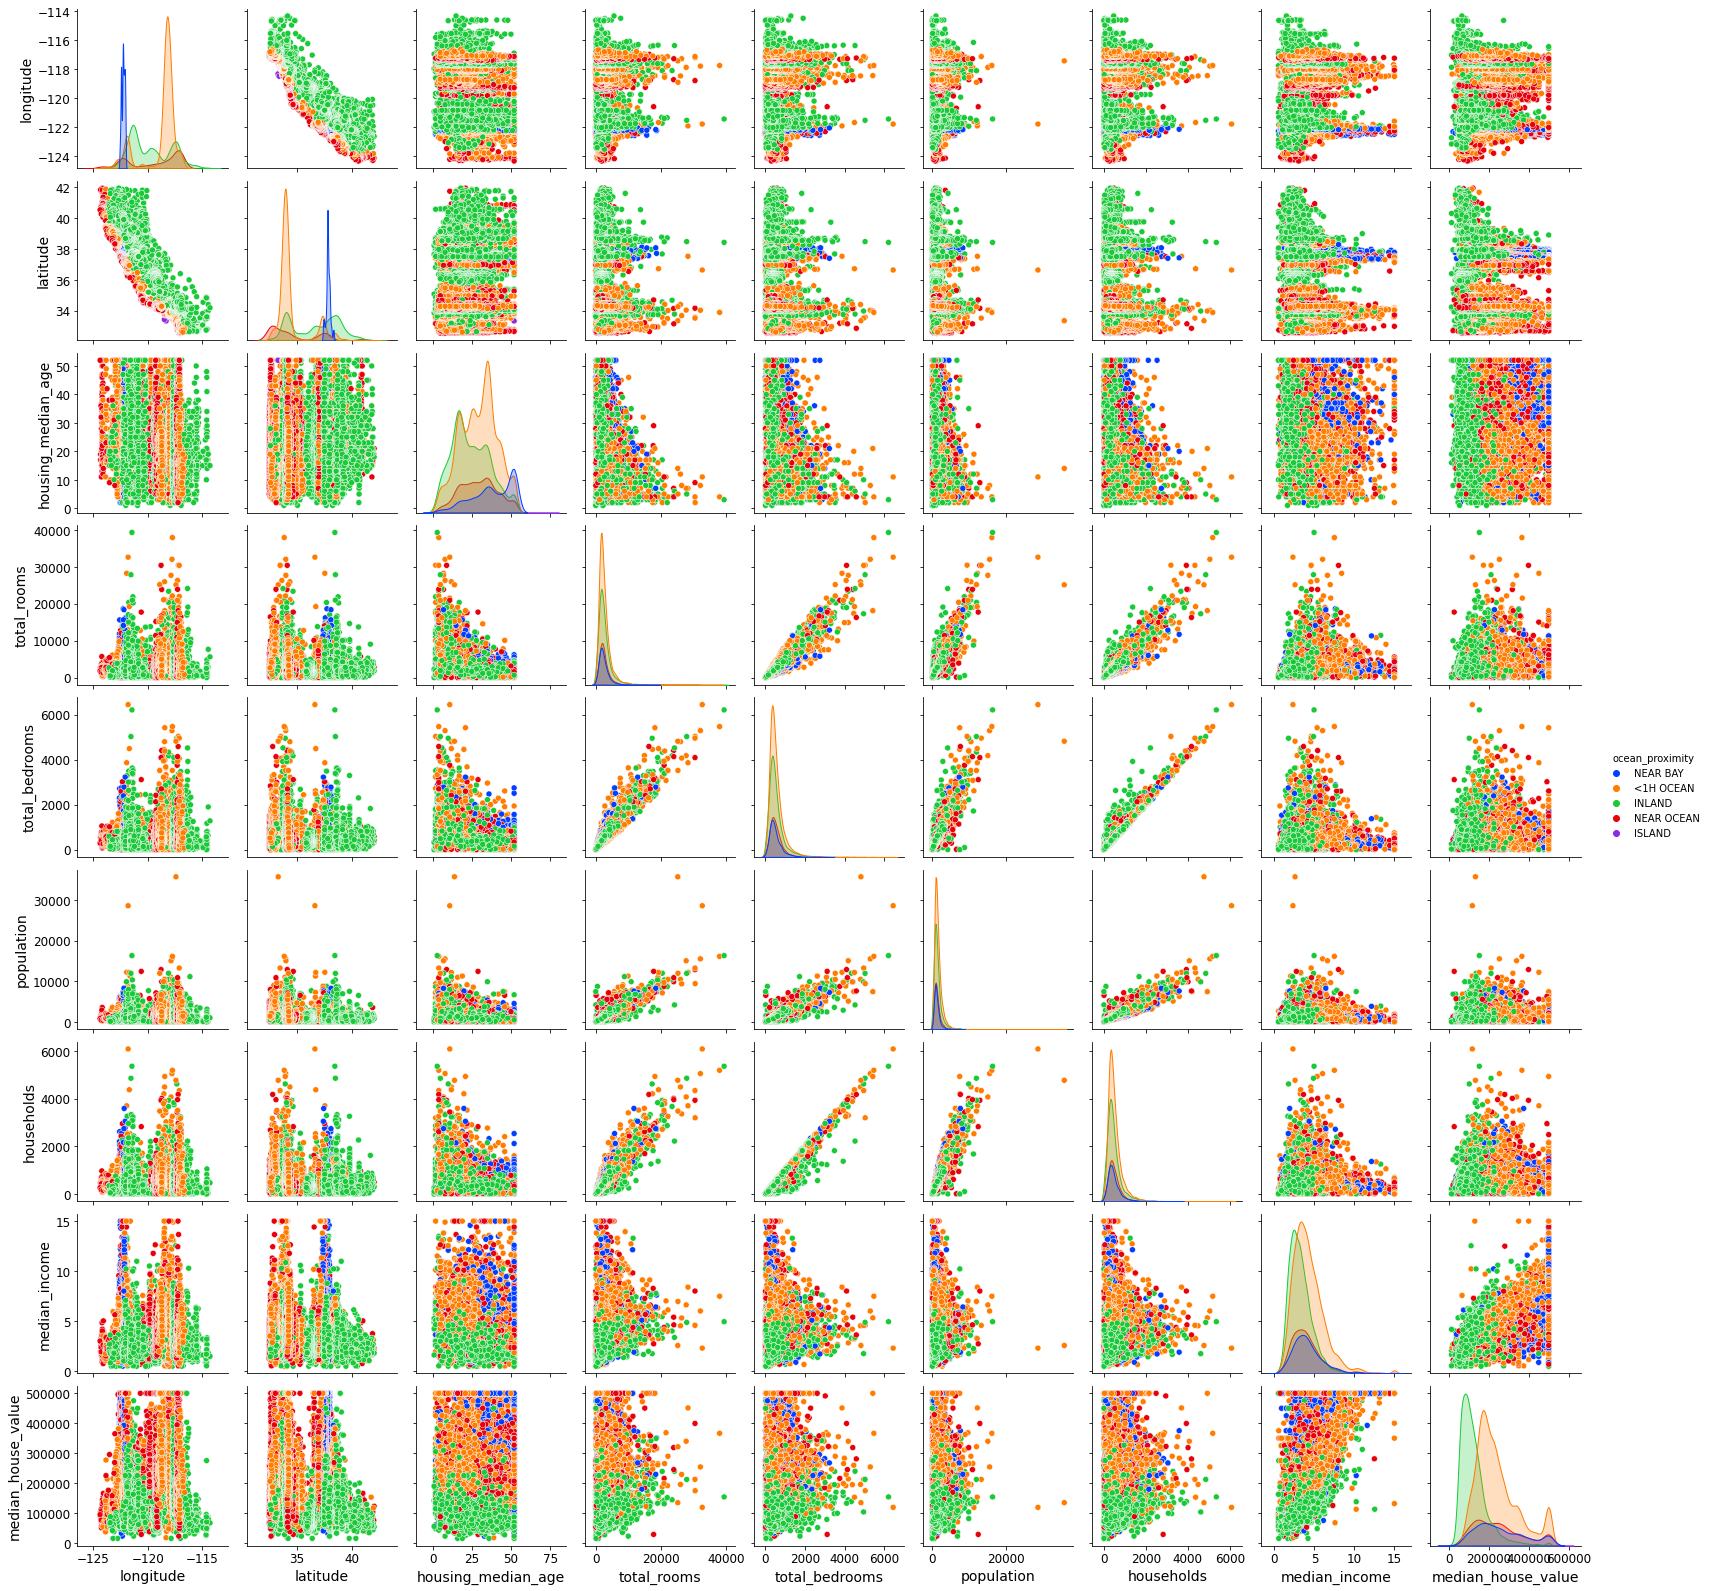

In [11]:
#Visualising scatterplots for each numerical attribute pairing
%matplotlib inline
sns.pairplot(housing, palette ='bright', hue = 'ocean_proximity' )
plt.show()

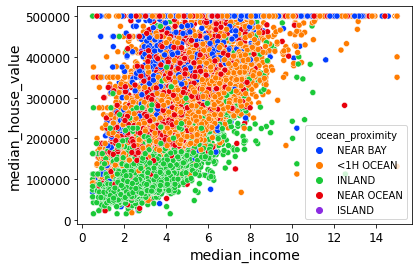

In [12]:
sns.scatterplot(
    x='median_income',
    y='median_house_value',
    data =housing,
    palette ='bright',
    hue = 'ocean_proximity')
plt.show()

## Splitting of Training and Test Sets

We specifically set aside a portion of the data, usually 20% of the dataset. The main reason behind this is, that when working with the whole dataset the model is likely to overfit on the data which will lead to a generalization error that is too optimistic contrary to the actual value, a phenomenon known as *data snooping bias*.

In [13]:
train_set,test_set = train_test_split(housing, test_size= 0.2, random_state=42)
print(train_set.shape, test_set.shape)

(16512, 10) (4128, 10)


In cases such as these where the dataset is not sufficiently large, using random sampling may tend to introduce, albeit unintentionally, significant sampling bias. Therefore, before proceeding we check whether features of the test set that are heavily correlated with the target label are representative of the overall dataset

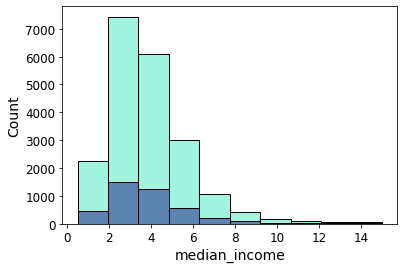

In [14]:
%matplotlib inline
sns.histplot(housing['median_income'], bins= 10, color = '#82f1d4')
sns.histplot(test_set['median_income'], bins= 10, color ='#455ea2') ##checking if the test set is representative of the data

Since the data is tail-heavy, we wil create a discrete income category from median income and create strata with sufficient instances in each. Once these strata are completed, we can carry out Stratified sampling.

In [15]:
#creating a discrete income category attribute from median income
housing['income_cat'] = np.ceil(housing['median_income']/1.5) #rounding up
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace= True)
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [16]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
#This sss class creates a set of list of indexes given n_splits number of iterations

for train_index, test_index in sss.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#To check wheher the test data set has the same proportion to the entire data set
#To ensure it is representative of the data
print(round((housing["income_cat"].value_counts() / len(housing)),2))
round((strat_test_set['income_cat'].value_counts()/len(strat_test_set)),2)

3.0    0.35
2.0    0.32
4.0    0.18
5.0    0.11
1.0    0.04
Name: income_cat, dtype: float64


3.0    0.35
2.0    0.32
4.0    0.18
5.0    0.11
1.0    0.04
Name: income_cat, dtype: float64

In [17]:
#dropping the income_cat attribute to restore the original data
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace = True)

## Training Set Data Visualization

In [18]:
#Exclusively using the train_set
housing = strat_train_set.copy()

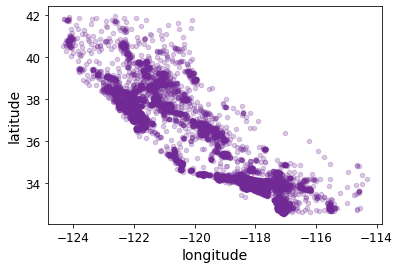

In [19]:
#mapping out the pop density 
%matplotlib inline
housing.plot(kind ='scatter', x = 'longitude', y = 'latitude', color='#712a95', alpha=0.25)
plt.show()

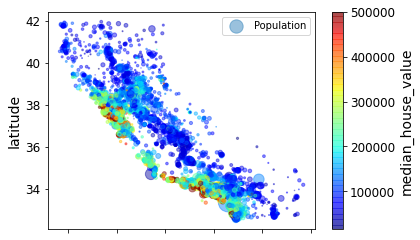

In [20]:
#map showing housing prices across the state
%matplotlib inline
housing.plot(kind ='scatter', x = 'longitude', y = 'latitude',
             alpha = 0.45, s=housing['population']/100, label='Population',
            c='median_house_value', cmap='jet', colorbar=True)
plt.legend()

## Feature Engineering & Data Cleaning

In [21]:
#looking for correlations between the target variable and other attributes
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Experimenting with feature combination to gain more insightful features

In [22]:
#number of rooms per household
housing['rooms/household']= housing['total_rooms']/housing['households']
#number of bedrooms per room
housing['bedroom_to_room']=housing['total_bedrooms']/housing['total_rooms']
#population per household
housing["population_per_household"]=housing["population"]/housing["households"]

In [23]:
#checking correlation of new attributes
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms/household             0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedroom_to_room            -0.259952
Name: median_house_value, dtype: float64

## Preparing the Data for ML Algorithms

In [24]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

In [25]:
#using sklearn Imputer to deal with missing values
imputer = SimpleImputer(strategy='median')

#dropping the ocean_proximity attr since median can only be computed on num values
housing_num = housing.drop('ocean_proximity', axis=1)
# print(housing_num.isnull().sum())
#fitting the imputer instance to the data
imputer.fit(housing_num)
#transforming the training set by replacing the missing values w/ learned medians
X = imputer.transform(housing_num) #returns np array


In [26]:
#imputer.statistics_ stores the results of the imputer
imputer.statistics_ == housing_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [27]:
#converting the numpy array back to a df
housing_tr = pd.DataFrame(X, columns =housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


### Handling of Text and categorical Attributes

In [28]:
encoder = LabelBinarizer(sparse_output = True)
housing_cat = housing['ocean_proximity']
#sparse_output converts the output from ndarray to sparse matrix ##saving on memory
housing_cat_1hot = encoder.fit_transform(housing_cat)

## Custom Transformers for Feature Scaling & Transformation Pipelines

It is possible to write custom transformers for cleanup and feature combination in Scikit-Learn. Since sklearn is dependent on duck-typing, instantiating a class and implementing three methods: fit(), transform() and fit_transform() is all that is required in creating custom transformers. Inheriting from the BaseEstimator class provides an additional two methods: get_params() and set_params(), useful for automatic hyperparameter tuning.

In [29]:
#a custom transformer for combining the numerical attributes

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): #TransformerMixin provides fit_transform()
    def __init__(self, add_br_per_room = True):  ##setting the hyperparameter add_br_per_room to True
        self.add_br_per_room = add_br_per_room
    def fit(self = X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:,3] / X[:,6]
        pop_per_household = X[:,5] / X[:,6]
        if self.add_br_per_room:
            br_per_room = X[:,4] / X[:, 3]
            return np.c_[X, rooms_per_household, pop_per_household, br_per_room]
        else:
            return np.c_[X, rooms_per_household, pop_per_household]
        
attr_adder  = CombinedAttributesAdder(add_br_per_room = False)
# housing_extra_attr = attr_adder.transform(housing_num)

In [30]:
##creating a custom transformer and a pipeline for numerical attributes

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)), #fit_transform()
    ('imputer', SimpleImputer(strategy='median')),#fit_transform()
    ('attrib_adder', CombinedAttributesAdder()),  #fit_transform()
    ('std_scaler',StandardScaler())               #fit()
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
print(type(housing_num_tr))

<class 'numpy.ndarray'>


In [31]:
cat_attribs = ['ocean_proximity']

#creating a custom transformer: MylabelBinarizer that takes 3 args instead of 2
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
         self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

##categorical variables pipeline
cat_pipeline =Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', MyLabelBinarizer()),
])
    


In [32]:
#joining transformers using FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)

print(type(housing_prepared))
print(housing_prepared.shape)
housing_prepared

<class 'numpy.ndarray'>
(16512, 16)


array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

## Selecting and Trainig a Model

In [33]:
#Training a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [34]:
#Trying out the preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:\t',lin_reg.predict(some_data_prepared))
print('Labels:\t\t', list(some_labels))

Predictions:	 [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [35]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
# lin_rmse = np.sqrt(lin_mse) #root mean square error
lin_rmse

68627.87390018745

In [36]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915802

In [37]:
#using decision tree to find any complex non-linear rlshp
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [38]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Performing K-fold Cross-Validation

In [39]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores =np.sqrt(-tree_scores)  #cross-validation expects a utility function hence the -scores


In [40]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [41]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error',cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634
